DATASETS to Upload:
POKEMON DATASET

#**Extreme Value Analysis Using Univariate Method**

In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=a69b2b29274695adcf9563daab2d0770c7637e8dde689729cd948d8ea6866401
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
# Import necessary libraries
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
from scipy.stats import zscore, median_abs_deviation
import pandas as pd
from pyod.models.mad import MAD
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
import plotly.express as px

In [ ]:
# Load and explore the "diamonds" dataset from seaborn
diamonds = sns.load_dataset("diamonds")
diamonds.head()  # Preview the first few rows of the dataset
diamonds.columns  # Check the columns available in the dataset

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')

In [ ]:
# Preprocess categorical features with OrdinalEncoder
X, y = diamonds.drop("carat", axis=1), diamonds["carat"]
cats = X.select_dtypes(exclude=np.number).columns.tolist()  # Identify categorical columns
X.loc[:, cats] = OrdinalEncoder().fit_transform(X[cats])  # Encode categorical columns

<ipython-input-4-3299455506d4>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2. 3. 1. ... 4. 3. 2.]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  X.loc[:, cats] = OrdinalEncoder().fit_transform(X[cats])  # Encode categorical columns
<ipython-input-4-3299455506d4>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 1. 1. ... 0. 4. 0.]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  X.loc[:, cats] = OrdinalEncoder().fit_transform(X[cats])  # Encode categorical columns
<ipython-input-4-3299455506d4>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3. 2. 4. ... 2. 3. 3.]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  X.loc[:, cats] = Or

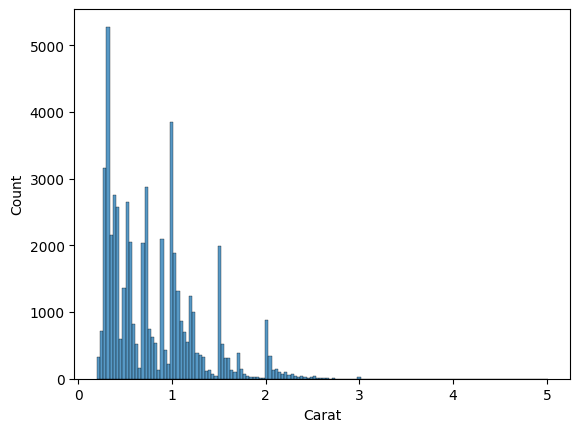

In [ ]:
# Summarize and visualize the target variable 'carat'
y.describe()
sns.histplot(y)
plt.xlabel("Carat");

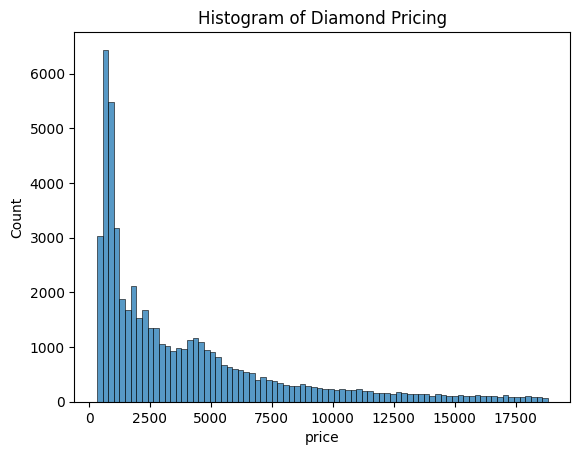

In [ ]:
# Explore the price feature before outlier analysis
X.drop(cats, axis=1).describe()
sns.histplot(X["price"])
plt.title("Histogram of Diamond Pricing")
plt.xlabel("price");

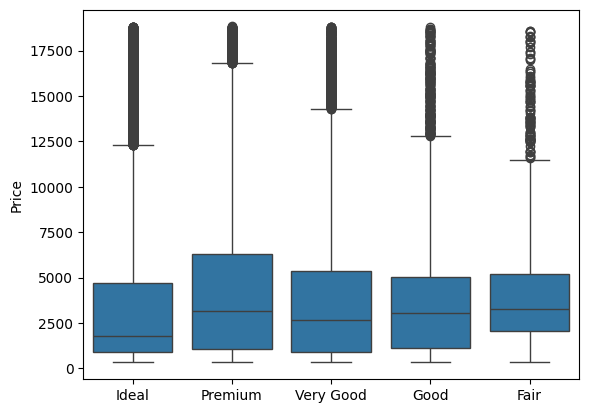

In [ ]:
# Visualize the relationship between diamond cut and price
sns.boxplot(x="cut", y="price", data=diamonds, whis=2)
plt.xlabel("")
plt.ylabel("Price");

In [ ]:
# Calculate z-scores for the target variable 'carat'
zscore(y).abs()[:5]

,carat
0,1.198168
1,1.240361
2,1.198168
3,1.071587
4,1.029394


In [ ]:
# Identify and quantify outliers using z-score method (threshold: |z| > 3)
is_outlier = zscore(y).abs() > 3
outliers_y = y[is_outlier]
num_outliers = len(outliers_y)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(y):.3f}")

The number of outliers: 439
Percentage of outliers: 0.008


In [ ]:
# Compute median absolute deviation (MAD) for 'carat'
median_y = y.median()
abs_diffs = (y - median_y).abs()  # Absolute differences from the median
mad = abs_diffs.median()  # Median of absolute differences

In [ ]:
# Alternatively, use scipy's built-in median_abs_deviation
median_abs_deviation(y)

0.32000000000000006

In [ ]:
!pip install pyod

In [ ]:
# Fit the MAD (Median Absolute Deviation) model from PyOD
y_2d = y.values.reshape(-1, 1)  # Reshape target to 2D for model input
mad = MAD().fit(y_2d)  # Fit MAD model to the target 'carat'
labels = mad.labels_  # Extract inlier (0) / outlier (1) labels

In [ ]:
# Outlier statistics based on MAD method
outliers_y_mad = y[labels == 1]
num_outliers = len(outliers_y_mad)
print(f"The number of outliers: {num_outliers}")
print(f"Percentage of outliers: {num_outliers / len(y):.3f}")

The number of outliers: 222
Percentage of outliers: 0.004


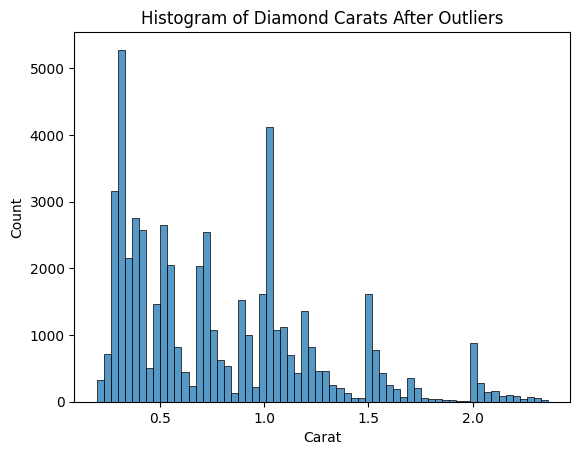

In [ ]:
# Visualize 'carat' distribution after removing outliers
inliers = y[labels == 0]
sns.histplot(inliers)
plt.title("Histogram of Diamond Carats After Outliers")
plt.xlabel("Carat");

In [ ]:
# Tukey's method for outlier detection
def tukey_method(data, threshold=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
    return outliers_indices

In [ ]:
list_to_label = tukey_method(y)
len(list_to_label)

1889

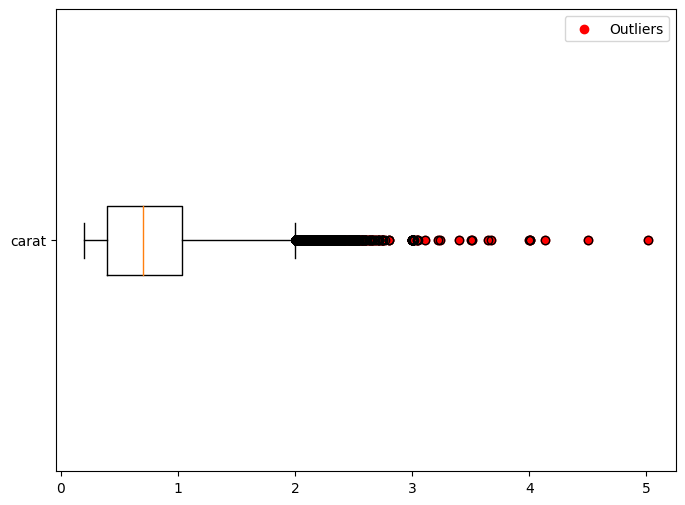

In [ ]:
# Boxplot highlighting outliers based on Tukey's method
plt.figure(figsize=(8, 6))
plt.boxplot(y, vert=False, labels=['carat'])
plt.scatter(y[list_to_label], [1] * len(list_to_label), color='red', label='Outliers')
plt.legend()
plt.show()

In [ ]:
print("Indexes of Outliers:", list_to_label)
print("Values of Outliers:", y[list_to_label])

Indexes of Outliers: [12246 13002 13118 ... 27744 27746 27749]
Values of Outliers: 12246    2.06
13002    2.14
13118    2.15
13757    2.22
13991    2.01
         ... 
27741    2.15
27742    2.04
27744    2.29
27746    2.07
27749    2.29
Name: carat, Length: 1889, dtype: float64


In [ ]:
# Mark outliers in the original dataframe and review them
df = pd.DataFrame(diamonds)
odf = pd.DataFrame(list_to_label, columns=['index'])
odf['outliers_status'] = 'yes'
df['index'] = df.index
df = df.join(odf.set_index('index'), on='index')
df[df['outliers_status'] == 'yes']

,carat,cut,color,clarity,depth,table,price,x,y,z,index,outliers_status
12246,2.06,Premium,J,I1,61.2,58.0,5203,8.10,8.07,4.95,12246,yes
13002,2.14,Fair,J,I1,69.4,57.0,5405,7.74,7.70,5.36,13002,yes
13118,2.15,Fair,J,I1,65.5,57.0,5430,8.01,7.95,5.23,13118,yes
13757,2.22,Fair,J,I1,66.7,56.0,5607,8.04,8.02,5.36,13757,yes
13991,2.01,Fair,I,I1,67.4,58.0,5696,7.71,7.64,5.17,13991,yes
...,...,...,...,...,...,...,...,...,...,...,...,...
27741,2.15,Ideal,G,SI2,62.6,54.0,18791,8.29,8.35,5.21,27741,yes
27742,2.04,Premium,H,SI1,58.1,60.0,18795,8.37,8.28,4.84,27742,yes
27744,2.29,Premium,I,SI1,61.8,59.0,18797,8.52,8.45,5.24,27744,yes
27746,2.07,Ideal,G,SI2,62.5,55.0,18804,8.20,8.13,5.11,27746,yes


#**Multivariate Analysis**

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving pokemon.csv to pokemon.csv


In [ ]:
pokemon = pd.read_csv('pokemon.csv')
pokemon.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [ ]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

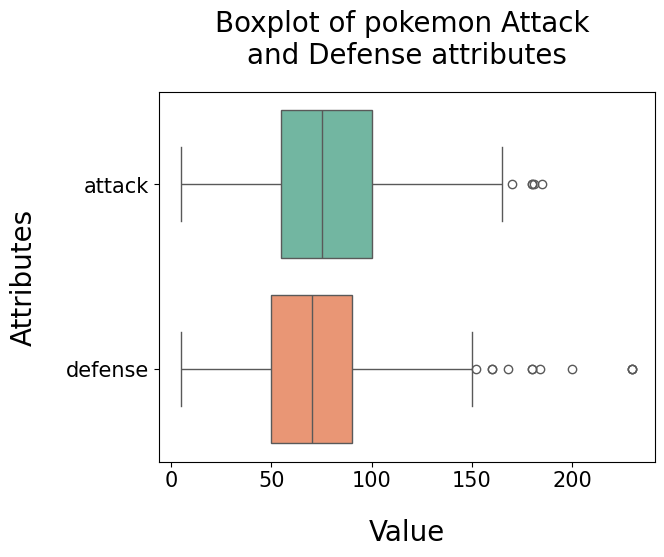

In [ ]:
#create the plot
ax = sns.boxplot(data = pokemon[["attack", "defense"]], orient = "h", palette = "Set2")
#add labels
ax.set_xlabel("Value", fontsize = 20, labelpad = 20)
ax.set_ylabel("Attributes", fontsize = 20, labelpad = 20)
ax.set_title("Boxplot of pokemon Attack \nand Defense attributes", fontsize = 20,
            pad = 20)
#edit ticks
ax.tick_params(which = "both", labelsize = 15)

In [ ]:
# Function to calculate IQR-based outlier bounds
def IQR_bounds(dataframe, column_name, multiple):
    """Extract the upper and lower bound for outlier detection using IQR

    Input:
        dataframe: Dataframe you want to extract the upper and lower bound from
        column_name: column name you want to extract upper and lower bound for
        multiple: The multiple to use to extract this

    Output:
        lower_bound = lower bound for column
        upper_bound = upper bound for column"""

    #extract the quantiles for the column
    lower_quantile = dataframe[column_name].quantile(0.25)
    upper_quantile = dataframe[column_name].quantile(0.75)
    #cauclat IQR
    IQR = upper_quantile - lower_quantile

    #extract lower and upper bound
    lower_bound = lower_quantile - multiple * IQR
    upper_bound = upper_quantile + multiple * IQR

    #retrun these values
    return lower_bound, upper_bound


In [ ]:
# Detect outliers in 'attack' and 'defense' using IQR bounds
columns = ["attack", "defense"]
column_bounds = {}
for column in columns:
    lower_bound, upper_bound = IQR_bounds(pokemon, column, 1.5)
    column_bounds[column] = [lower_bound, upper_bound]
pokemon_IQR_AD = pokemon[(pokemon["attack"] < column_bounds["attack"][0]) |
                         (pokemon["attack"] > column_bounds["attack"][1]) |
                         (pokemon["defense"] < column_bounds["defense"][0]) |
                         (pokemon["defense"] > column_bounds["defense"][1])]
pokemon_IQR_AD.shape

(15, 41)

##***Isolation Forest***

In [ ]:
from sklearn.ensemble import IsolationForest

#create the method instance
isf = IsolationForest(n_estimators = 100, random_state = 42, contamination = 0.02)

#use fit_predict on the data as we are using all the data
preds = isf.fit_predict(pokemon[["attack", "defense"]])

#extract outliers from the data
pokemon["iso_forest_outliers"] = preds
pokemon["iso_forest_outliers"] = pokemon["iso_forest_outliers"].astype(str)

#extract the scores from the data in terms of strength of outlier
pokemon["iso_forest_scores"] = isf.decision_function(pokemon[["attack", "defense"]])

#print how many outliers the data suggests
print(pokemon["iso_forest_outliers"].value_counts())

iso_forest_outliers
1     785
-1     16
Name: count, dtype: int64


In [ ]:
#this plot will be repeated so it is better to create a function
def scatter_plot(dataframe, x, y, color, title, hover_name):
    """Create a plotly express scatter plot with x and y values with a colour

    Input:
        dataframe: Dataframe containing columns for x, y, colour and hover_name data
        x: The column to go on the x axis
        y: Column name to go on the y axis
        color: Column name to specify colour
        title: Title for plot
        hover_name: column name for hover

    Returns:
        Scatter plot figure
    """
    #create the base scatter plot
    fig = px.scatter(dataframe, x = x, y=y,
                    color = color,
                     hover_name = hover_name)
    #set the layout conditions
    fig.update_layout(title = title,
                     title_x = 0.5)
    #show the figure
    fig.show()

<Axes: xlabel='iso_forest_scores', ylabel='Count'>

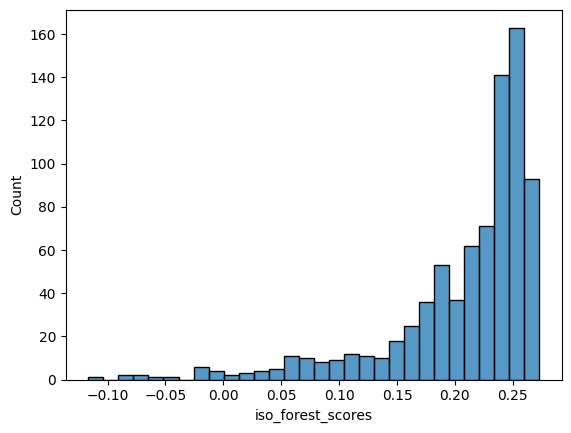

In [ ]:
# Visualize Isolation Forest results
scatter_plot(pokemon, "attack", "defense", "iso_forest_outliers", "Isolation Forest Outlier Detection", "name")
scatter_plot(pokemon, "attack", "defense", "iso_forest_scores", "Isolation Forest Outlier Detection Scores", "name")
sns.histplot(pokemon['iso_forest_scores'])

<Axes: xlabel='iso_forest_scores', ylabel='Count'>

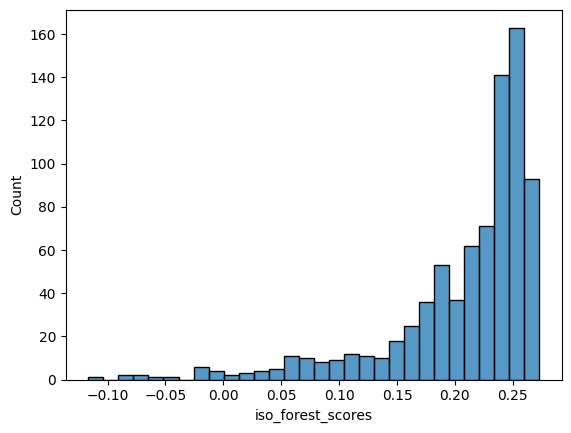

In [ ]:
sns.histplot(pokemon['iso_forest_scores'])

##***Local Outlier Factor***

In [ ]:
#import the algorithm
from sklearn.neighbors import LocalOutlierFactor

# Local Outlier Factor (LOF) for multivariate outlier detection
lof = LocalOutlierFactor(n_neighbors=20)
y_pred = lof.fit_predict(pokemon[["attack", "defense"]])
pokemon["lof_outliers"] = y_pred.astype(str)  # Label outliers (-1) and inliers (1)
pokemon["lof_scores"] = lof.negative_outlier_factor_

In [ ]:
# Visualize LOF results
scatter_plot(pokemon, "attack", "defense", "lof_outliers", "Local Outlier Factor Detection", "name")
scatter_plot(pokemon, "attack", "defense", "lof_scores", "Local Outlier Factor Detection Scores", "name")

In [ ]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   abilities            801 non-null    object 
 1   against_bug          801 non-null    float64
 2   against_dark         801 non-null    float64
 3   against_dragon       801 non-null    float64
 4   against_electric     801 non-null    float64
 5   against_fairy        801 non-null    float64
 6   against_fight        801 non-null    float64
 7   against_fire         801 non-null    float64
 8   against_flying       801 non-null    float64
 9   against_ghost        801 non-null    float64
 10  against_grass        801 non-null    float64
 11  against_ground       801 non-null    float64
 12  against_ice          801 non-null    float64
 13  against_normal       801 non-null    float64
 14  against_poison       801 non-null    float64
 15  against_psychic      801 non-null    flo

In [ ]:
pokemon['capture_rate'].unique()

array(['45', '255', '120', '127', '90', '190', '75', '235', '150', '25',
       '170', '50', '200', '100', '180', '60', '225', '30', '35', '3',
       '65', '70', '125', '205', '155', '145', '130', '140', '15', '220',
       '160', '80', '55', '30 (Meteorite)255 (Core)'], dtype=object)

In [ ]:
pokemon_num = pokemon[['attack', 'defense', 'capture_rate', 'hp', 'speed', 'height_m', 'weight_kg', 'sp_attack', 'sp_defense', 'iso_forest_outliers', 'iso_forest_scores']]

In [ ]:
pokemon_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   attack               801 non-null    int64  
 1   defense              801 non-null    int64  
 2   capture_rate         801 non-null    object 
 3   hp                   801 non-null    int64  
 4   speed                801 non-null    int64  
 5   height_m             781 non-null    float64
 6   weight_kg            781 non-null    float64
 7   sp_attack            801 non-null    int64  
 8   sp_defense           801 non-null    int64  
 9   iso_forest_outliers  801 non-null    object 
 10  iso_forest_scores    801 non-null    float64
dtypes: float64(3), int64(6), object(2)
memory usage: 69.0+ KB


In [ ]:
pokemon_num.select_dtypes(include = 'number').fillna(pokemon_num.select_dtypes(include = 'number').mean(), inplace=True)

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(pokemon_num, hue='iso_forest_outliers')

Output hidden; open in https://colab.research.google.com to view.

##***DBScans***

In [ ]:
from sklearn.cluster import DBSCAN

#initiate the algorithm
#set the distance to 20, and min_samples as 5
outlier_detection = DBSCAN(eps = 20, metric = "euclidean", min_samples = 10, n_jobs = -1)

#fit_predict the algorithm to the existing data
clusters = outlier_detection.fit_predict(pokemon[["attack", "defense"]])

#extract the labels from the algorithm
pokemon["dbscan_outliers"] = clusters

#label all others as inliers
pokemon["dbscan_outliers"] = pokemon["dbscan_outliers"].apply(lambda x: str(1) if x>-1 else str(-1))

#print the vaue counts
print(pokemon["dbscan_outliers"].value_counts())

dbscan_outliers
1     787
-1     14
Name: count, dtype: int64


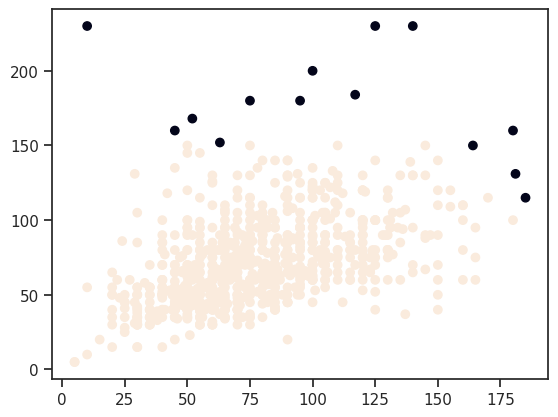

In [ ]:
# Visualize DBSCAN results
colors = outlier_detection.labels_
plt.scatter(pokemon["attack"], pokemon["defense"], c=colors)